In [28]:
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np

import tensorflow as tf
import keras
from keras import backend as K
from keras.layers import Conv2D, Dense, ReLU, BatchNormalization, Input, Flatten, Concatenate, Reshape, UpSampling2D,\
Activation, Conv2DTranspose, LeakyReLU
from keras import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.metrics import Mean

from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from keras.losses import BinaryCrossentropy

from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load MNIST digits data set

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [3]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10, dtype=np.float32)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10, dtype=np.float32)

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28, 1), (60000, 10), (10000, 28, 28, 1), (10000, 10))

In [5]:
def mnist_transform(x):
    return (tf.cast(x, tf.float32) / 127.5) - 1.0

C:\Users\Chirag\AppData\Local\Temp\ipykernel_29428\3310703368.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


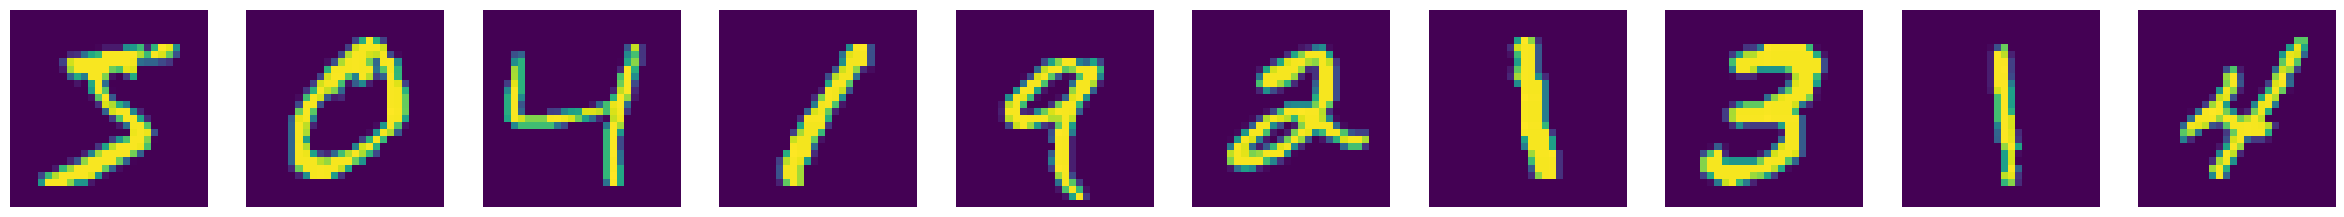

In [6]:
fig, ax = plt.subplots(1, 10, figsize=(30, 50))
for i in range(10):
    ax[i].imshow(mnist_transform(x_train[i, :, :, :]))
    ax[i].axis('off')
fig.show()

## Define Conditional GAN model class

In [103]:
z_dim = 100
num_classes = 10
img_shape = (28, 28, 1)

In [156]:
Z_DIM = 100
NUM_CLASSES = 10
IMG_SHAPE = (28, 28, 1)

In [157]:
class CGAN(keras.Model):
    def __init__(self):
        super().__init__()
        self.discriminator = self._build_discriminator()
        self.generator = self._build_generator()
        
    def compile_model(self, discriminator_optimizer, generator_optimizer, loss_fn):
        super().compile()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.loss_fn = loss_fn
        
        self.discriminator.compile(loss=self.loss_fn,
                                  optimizer=self.discriminator_optimizer)
        
        self.generator.compile(loss=self.loss_fn,
                                  optimizer=self.generator_optimizer)
        self.discriminator_loss_metric = Mean(name='d_loss')
        self.generator_loss_metric = Mean(name='g_loss')
        
    def _build_generator(self):
        img = Input((Z_DIM,))
        labels = Input((NUM_CLASSES,))

        z = Concatenate()([img, labels])
        z = Dense(np.prod(IMG_SHAPE), 'relu')(z)
        
        z = Reshape(IMG_SHAPE)(z)
        
        z = Conv2D(
            filters=128,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='relu',
        )(z)
        
        z = BatchNormalization()(z)

        z = UpSampling2D()(z)
        z = Conv2D(
            filters=128,
            kernel_size=3,
            strides=2,
            padding='same',
            activation='relu',
        )(z)
        z = BatchNormalization()(z)
        z = Conv2D(
            filters=64,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='relu',
        )(z)
        z = BatchNormalization()(z)
        z = Conv2D(
            filters=32,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='relu',
        )(z)
        z = BatchNormalization()(z)
        
        output = Conv2D(
            filters=IMG_SHAPE[-1],
            kernel_size=3,
            strides=1,
            padding='same',
            activation='tanh',
        )(z)

        return Model(inputs=[img, labels], outputs=output)
    
    def _build_discriminator(self):
        img = Input(IMG_SHAPE)
        labels = Input((NUM_CLASSES,))
        
        z = Conv2D(
            filters=32,
            kernel_size=3,
            strides=2,
            padding='same',
            activation='relu',
        )(img)
        
        z = Conv2D(
            filters=128,
            kernel_size=3,
            strides=2,
            padding='same',
            activation='relu',
        )(z)
        
        z = Conv2D(
            filters=64,
            kernel_size=3,
            strides=2,
            padding='same',
            activation='relu',
        )(z)
        
        z = Flatten()(z)
        
        z = Concatenate()([z, labels])
        z = Dense(128, activation='relu')(z)
        z = Dense(64, activation='relu')(z)
        
        z = Dense(1, activation='sigmoid')(z)
        
        output = z
        return Model(inputs=[img, labels], outputs=output)
    
    def train_step(self, batch_data):
        img, labels = batch_data
        real_target_labels = np.ones((batch_size, 1), dtype=np.float32)
        fake_target_labels = np.zeros((batch_size, 1), dtype=np.float32)
        
        for _ in range(1):
            with tf.GradientTape() as tape:
                # Discriminator Loss
                real_predictions = self.discriminator((img, labels), training=True)
                real_d_loss = self.loss_fn(real_predictions, real_target_labels)

                z = tf.random.normal((batch_size, Z_DIM))
                fake_img = self.generator((z, labels), training=False)
                fake_predictions = self.discriminator((fake_img, labels), training=True)
                fake_d_loss = self.loss_fn(fake_predictions, fake_target_labels)

                d_loss = real_d_loss + fake_d_loss

            gradients = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.discriminator_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_weights))
        
        with tf.GradientTape() as tape:
            # Generator Loss
            z = tf.random.normal((batch_size, Z_DIM))
            fake_img = self.generator((z, labels), training=True)
            fake_predictions = self.discriminator((fake_img, labels), training=False)
            g_loss = self.loss_fn(fake_predictions, real_target_labels)
            
        gradients = tape.gradient(g_loss, self.generator.trainable_weights)
        self.generator_optimizer.apply_gradients(zip(gradients, self.generator.trainable_weights))
        
        self.discriminator_loss_metric.update_state(d_loss)
        self.generator_loss_metric.update_state(g_loss)
        
        return {m.name: m.result() for m in self.metrics}
    
    @property
    def metrics(self):
        return [self.discriminator_loss_metric, self.generator_loss_metric]

In [168]:
CGAN().discriminator.summary()

Model: "model_53"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_65 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_137 (Conv2D)            (None, 14, 14, 32)   320         ['input_65[0][0]']               
                                                                                                  
 conv2d_138 (Conv2D)            (None, 7, 7, 128)    36992       ['conv2d_137[0][0]']             
                                                                                                  
 conv2d_139 (Conv2D)            (None, 4, 4, 64)     73792       ['conv2d_138[0][0]']             
                                                                                           

In [146]:
def wasserstein_loss(y_true, y_pred):
    return - K.mean(y_true * y_pred)

## Define parameters

In [160]:
epochs = 10
batch_size = 128

generator_optimizer = Adam(learning_rate=4e-5)
discriminator_optimizer = Adam(learning_rate=1e-6)

loss_fn = wasserstein_loss

## Define a Data Iterator

In [161]:
train_data = tf.data.Dataset.from_tensor_slices(x_train) \
                .map(lambda x: mnist_transform(x)) \
                .batch(batch_size, drop_remainder=True) \
                .shuffle(1024, reshuffle_each_iteration=True)

## Define Callback

In [162]:
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.d_losses = []
        self.g_losses = []
        
    def on_batch_end(self, batch, logs):
        self.d_losses.append(logs['d_loss'])
        self.g_losses.append(logs['g_loss'])
        
    def on_epoch_end(self, epoch, logs):
        fig, ax = plt.subplots(10, 10, figsize=(20, 20))
        for i in range(10):
            labels = tf.keras.utils.to_categorical(np.arange(10), num_classes=10, dtype=np.float32)
            z = tf.random.normal((10, z_dim))
            generated_digit = self.model.generator(z, training=False)
            for j in range(10):
                ax[i][j].matshow(np.clip(generated_digit[j]*127.5 + 127.5, 0, 255).astype(int), cmap='viridis')
                ax[i][j].axis('off')
        fig.savefig(f"../data/tmp/mnist/generated_digits_{epoch:03}.png")
        plt.close()
        
    def on_train_end(self, logs):
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        ax.plot(self.d_losses, label='Discriminator loss')
        ax.plot(self.g_losses, label='Generator loss')
        ax.legend()
        fig.savefig(f"../data/tmp/mnist/training_losses.png")
        plt.close()

In [150]:
callback = CustomCallback()

## Train CGAN model

In [163]:
cgan = CGAN()

In [164]:
cgan.compile_model(discriminator_optimizer, generator_optimizer, loss_fn)

In [165]:
cgan.fit(train_data,
         epochs=epochs,
         callbacks=[callback]
        )

Epoch 1/10


OperatorNotAllowedInGraphError: in user code:

    File "C:\Users\Chirag\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Chirag\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Chirag\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Chirag\AppData\Local\Temp\ipykernel_29428\4262785277.py", line 116, in train_step
        img, labels = batch_data

    OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.


C:\Users\Chirag\AppData\Local\Temp\ipykernel_29428\3219454633.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


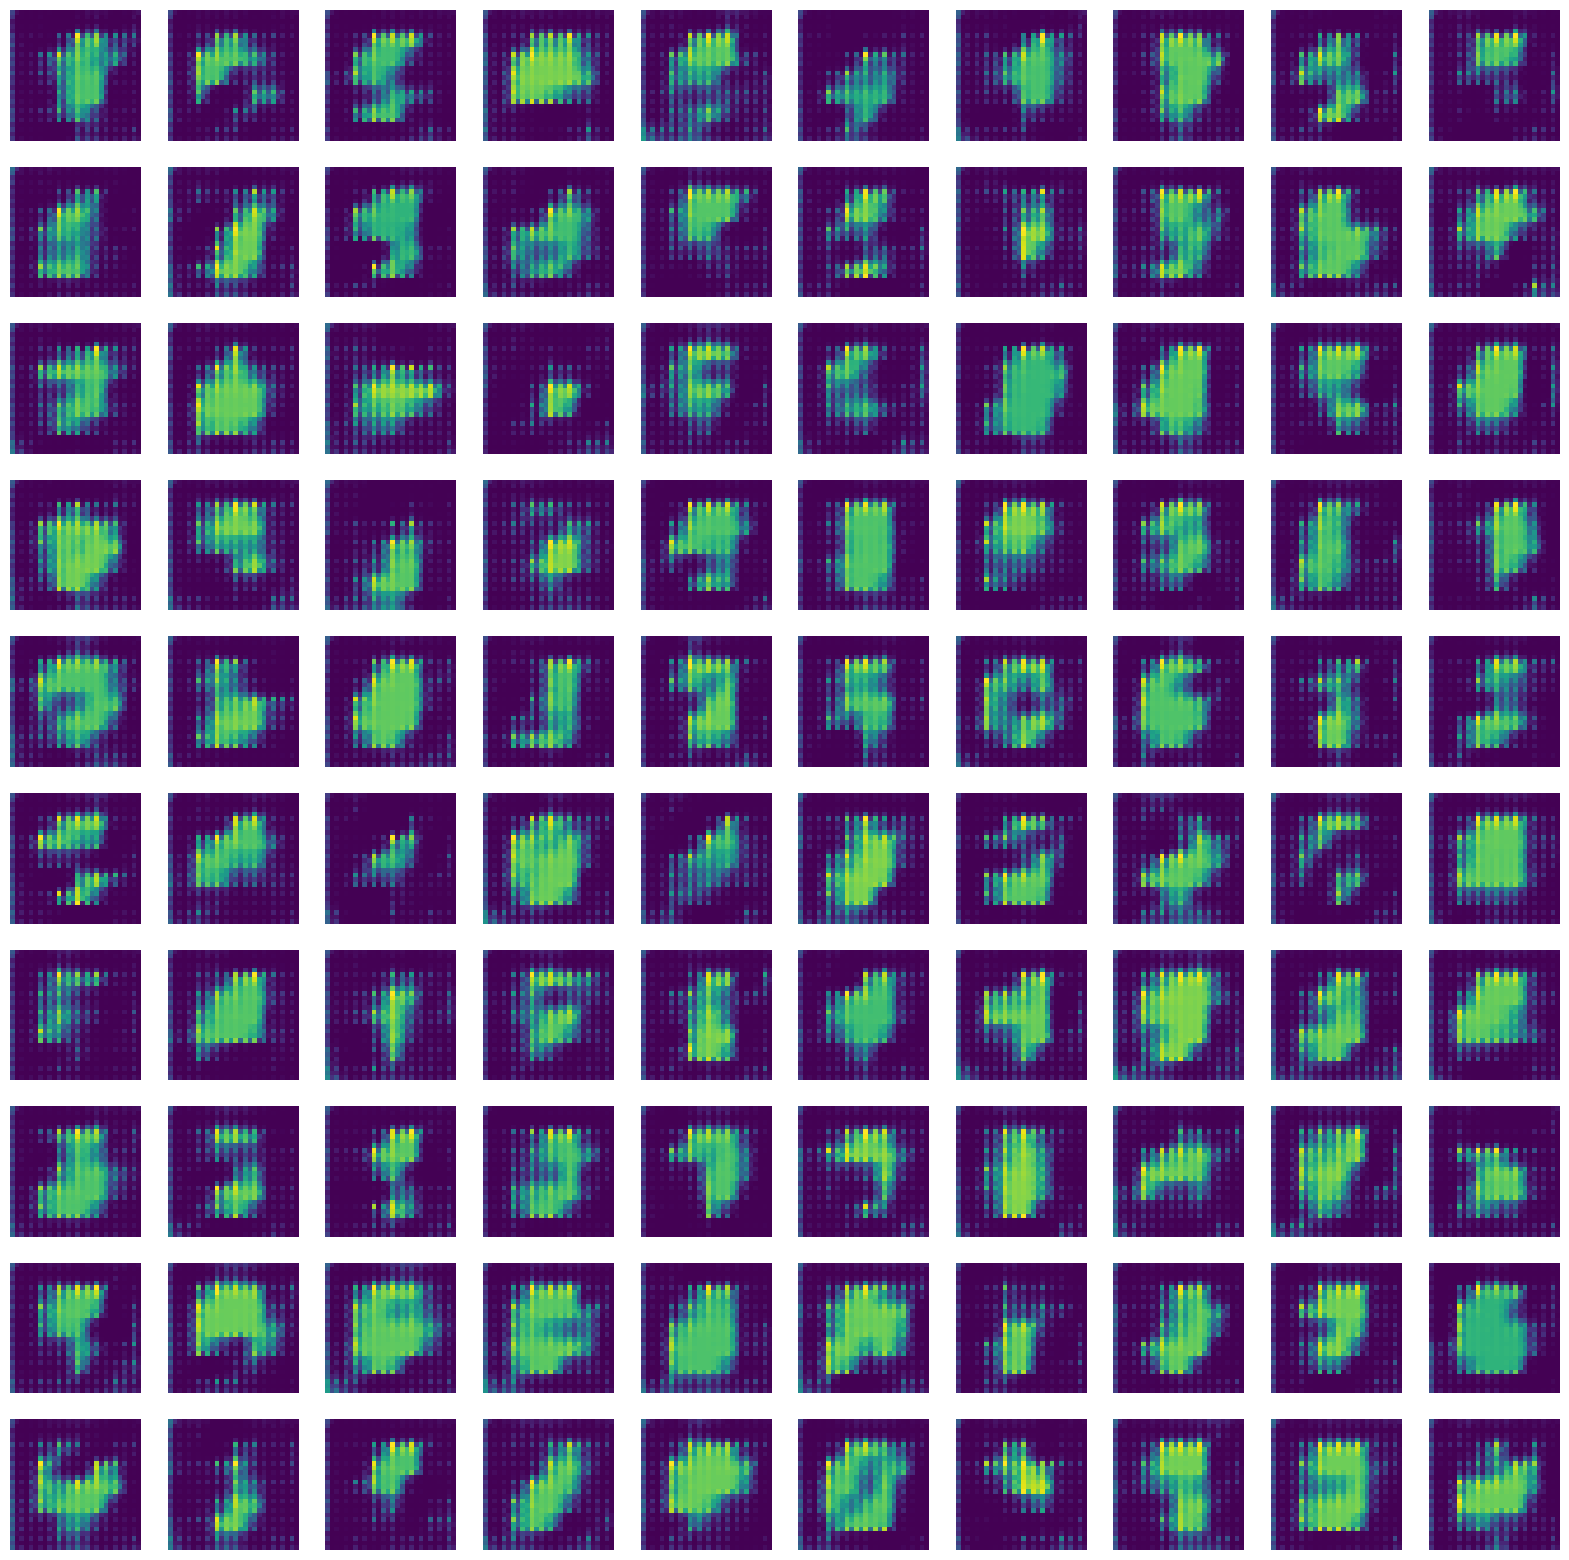

In [90]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    labels = tf.keras.utils.to_categorical(np.arange(10), num_classes=10, dtype=np.float32)
    z = tf.random.normal((10, z_dim))
    generated_digit = cgan.generator(z, training=False)
    for j in range(10):
        ax[i][j].imshow(np.clip(generated_digit[j]*127.5 + 127.5, 0, 255).astype(int))
        ax[i][j].axis('off')
fig.show()

In [ ]:
plt.matshow(x_train[1])